# Import modules

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os
import linecache

# Get model architecture

In [2]:
model_signature_directory = '../thesis/model_architecture.csv'
model = tf.saved_model.load("../pretrained_model/saved_model_with_signatures")

if not os.path.exists(model_signature_directory):
    # Collecting signature details
    signatures_data = []

    # Iterate over each signature in the model
    for key, signature in model.signatures.items():
        # Initialize dictionaries for current signature's inputs and outputs
        inputs_dict = {}
        outputs_dict = {}

        # Iterate over inputs and outputs, filling in the dictionaries
        for input_key, input_val in signature.structured_input_signature[1].items():
            inputs_dict[input_key] = str(input_val.dtype.name)

        for output_key, output_val in signature.structured_outputs.items():
            outputs_dict[output_key] = str(output_val.dtype.name)

        # Append the current signature's details to the list
        signatures_data.append({
            "Signature Key": key,
            "Inputs": inputs_dict,
            "Outputs": outputs_dict
        })

    # Convert list of signature data into a DataFrame for visualization
    df_signatures = pd.DataFrame(signatures_data)

    df_inputs = df_signatures["Inputs"].apply(pd.Series)
    df_outputs = df_signatures["Outputs"].apply(pd.Series)
    df_signatures = pd.concat([df_signatures.drop(['Inputs', 'Outputs'], axis=1), df_inputs, df_outputs], axis=1)
    df_signatures.set_index('Signature Key', drop=True, inplace=True)
    df_signatures.to_csv(model_signature_directory, index=True)
else:
    df_signatures = pd.read_csv(model_signature_directory, index_col='Signature Key')

In [3]:
df_signatures

,target_seq_len,embedding_sample,target_pos,inp_embeddings,inp_pos,input_stroke,input_seq_len,pen,seq_len,stroke,embedding_sample.1,sigma,mu,pi,position_sample
Signature Key,,,,,,,,,,,,,,,
decode_stroke,int32,float32,NaN,NaN,NaN,NaN,NaN,float32,int32,float32,NaN,NaN,NaN,NaN,NaN
predict_embedding,NaN,NaN,float32,float32,float32,NaN,NaN,NaN,NaN,NaN,float32,float32,float32,float32,NaN
predict_position,NaN,NaN,NaN,float32,float32,NaN,NaN,NaN,NaN,NaN,NaN,float32,float32,float32,float32
encode_stroke,NaN,NaN,NaN,NaN,NaN,float32,int32,NaN,NaN,NaN,float32,NaN,NaN,NaN,NaN
forward_pass,int32,NaN,NaN,NaN,NaN,float32,int32,float32,int32,float32,float32,NaN,NaN,NaN,NaN


# Preprocess drawings

## Visualize sample drawing (first row)

before [[[16, 33.507999420166016, 44.75699996948242, 52.5620002746582, 58.189998626708984, 64.90499877929688, 73.16600036621094, 82.36599731445312, 90.95600128173828, 99.41999816894531, 109, 120.08799743652344, 133.61000061035156, 146.77200317382812, 159.43699645996094, 170.01199340820312, 178.48899841308594, 186.35000610351562, 192.79299926757812, 199.4720001220703, 204.9949951171875, 210.7969970703125, 217.86000061035156, 224.9029998779297, 231.375, 238.53799438476562, 245.947998046875, 252.15699768066406, 259.3489990234375, 266.2959899902344, 273, 280.8179931640625, 288.7170104980469, 296.7380065917969, 304.24200439453125, 312.3080139160156, 321.2250061035156, 330.1130065917969, 338.84600830078125, 347.125, 350.1159973144531], [350, 351.0889892578125, 353.135009765625, 355.37799072265625, 359.0950012207031, 361.67999267578125, 362.7179870605469, 363.2080078125, 363.3330078125, 363.3330078125, 363, 362.0660095214844, 360.76300048828125, 359.72601318359375, 358.3590087890625, 357.3330

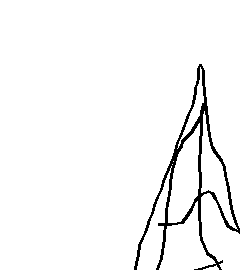

In [4]:
import json
from PIL import Image, ImageDraw
from IPython.display import display  

# read ndjson lines
lines = open('data/raw_The_Eiffel_Tower.ndjson','r').readlines()
# grab the first line, JSON parse it and fetch the 'drawing' array
raw_drawing = json.loads(lines[0])['drawing']

print('before',raw_drawing)
# zip x,y coordinates for each point in every polyline
polylines = list((zip(polyline[0], polyline[1]) for polyline in raw_drawing))
# notice how the data is shuffled to (x1,y1),(x2,y2) order
print('after',polylines)

# make a new image
pil_img = Image.new("RGB", (240, 270), (255,255,255))
# get a drawing context
d = ImageDraw.Draw(pil_img)
# render each polyline
for polyline in polylines:
    # Flatten the list of tuples into a single list of coordinates
    polyline_flat = [coord for point in polyline for coord in point]
    d.line(polyline_flat,fill=(0, 0, 0), width=3)

# display image
display(pil_img)

## Parse preprocessed drawings into TFRecord

In [5]:
# type the following in the terminal to convert raw ndjson file to TFRecord 
# python thesis/data_preprocessing.py

In [6]:
def _parse_function(example_proto):
     # Define the feature structure of TF_example
    feature_description = {
        'key': tf.io.FixedLenFeature([], tf.string),
        'label_id': tf.io.FixedLenFeature([], tf.string),
        'ink': tf.io.VarLenFeature(tf.float32),
        'stroke_length': tf.io.VarLenFeature(tf.int64),
        'shape': tf.io.FixedLenFeature([3], tf.int64),
        'num_strokes': tf.io.FixedLenFeature([], tf.int64)
    }

    # Parse the input tf.train.Example proto based on feature_description
    return tf.io.parse_single_example(example_proto, feature_description)

In [7]:
tfrecord_path = 'data/raw_The_Eiffel_Tower-00000-of-00001.tfrecord'
raw_drawing_dataset = tf.data.TFRecordDataset(tfrecord_path)
parsed_drawing_dataset = raw_drawing_dataset.map(_parse_function)

parsed_drawing_dataset

<_MapDataset element_spec={'ink': SparseTensorSpec(TensorShape([None]), tf.float32), 'stroke_length': SparseTensorSpec(TensorShape([None]), tf.int64), 'key': TensorSpec(shape=(), dtype=tf.string, name=None), 'label_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'num_strokes': TensorSpec(shape=(), dtype=tf.int64, name=None), 'shape': TensorSpec(shape=(3,), dtype=tf.int64, name=None)}>

In [8]:
# In this code, I just sample the first record
for parsed_features in parsed_drawing_dataset.take(1):
    ink = tf.sparse.to_dense(parsed_features['ink'])
    shape = parsed_features['shape']
    stroke_length = tf.sparse.to_dense(parsed_features['stroke_length'])
    
    # Reshape ink data to original dimensions (num_strokes, max_len, 4)
    reshaped_ink = tf.reshape(ink, shape)

2024-04-26 13:24:13.791952: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


## Undo preprocessing and do visualization again

In [9]:
from undo_data_preprocessing import undo_preprocessing
lines = open('data/raw_The_Eiffel_Tower.ndjson','r').readlines()
original_drawing = json.loads(lines[0])['drawing']
reversed_strokes = undo_preprocessing(reshaped_ink, stroke_length, original_drawing)

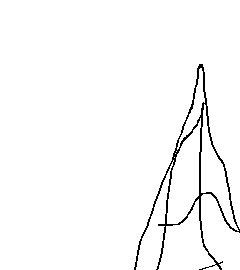

In [105]:
from stroke_visualization import visualize_stroke
visualize_stroke(reversed_strokes)

# Preprocesses raw drawings and get the right input format for `encode_stroke`

In [11]:
# Define functions to adjusts all drawings to have a consistent scale or size
def get_bounding_box(drawing):
    minx = 99999
    miny = 99999
    maxx = 0
    maxy = 0

    for s in drawing:
      minx = min(minx, min(s[0]))
      maxx = max(maxx, max(s[0]))
      miny = min(miny, min(s[1]))
      maxy = max(maxy, max(s[1]))
    return (minx, miny, maxx, maxy)

def size_normalization(drawing):
  bb = get_bounding_box(drawing)
  width, height = bb[2] - bb[0], bb[3] - bb[1]
  offset_x, offset_y = bb[0], bb[1]
  if height < 1e-6:
     height = 1

  size_normalized_drawing = [[[(x - offset_x) / width for x in stroke[0]],
                              [(y - offset_y) / height for y in stroke[1]],
                              [t for t in stroke[2]]]
                             for stroke in drawing]

  return size_normalized_drawing

In [12]:
# Define a function to resample the ink to have uniform time steps
# (Ensure that each point is separated by a constant time step)
def resample_ink(drawing, timestep=20):
    resampled_drawing = []
    
    for stroke in drawing:
        # Initialize with the first point
        resampled_stroke = [[stroke[0][0], stroke[1][0], stroke[2][0]]]  
        
        for i in range(1, len(stroke[0])):
            x0, y0, t0 = stroke[0][i-1], stroke[1][i-1], stroke[2][i-1]
            x1, y1, t1 = stroke[0][i], stroke[1][i], stroke[2][i]
            distance = np.sqrt((x1 - x0)**2 + (y1 - y0)**2)
            if distance == 0:
                continue
            else:
                new_points = max(1, int(distance / timestep))
                for j in range(1, new_points + 1):
                    new_point = [x0 + j * (x1 - x0) / new_points,
                                y0 + j * (y1 - y0) / new_points,
                                t0 + j * (t1 - t0) / new_points]
                    resampled_stroke.append(new_point)
        
        resampled_drawing.append(resampled_stroke)

    return resampled_drawing

Here I try with the first drawing in quick_draw_Eiffel_Tower:

In [13]:
ndjson_file_path = 'full_raw_The_Eiffel_Tower.ndjson'

# Select the line to read as the sample drawing
line_number = 1
# Use linecache to get the specific line
line = linecache.getline(ndjson_file_path, line_number).strip()
# Parse the JSON content from the line
selected_row = json.loads(line)

sample_drawing = selected_row["drawing"]
print(f"There are totally {len(sample_drawing)} strokes in the sample drawing")

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
# Sequence length for each stroke
[len(i[0]) for i in sample_drawing]

In [ ]:
# Preprocess the drawing
drawing_normalized = size_normalization(sample_drawing)
drawing_resampled = resample_ink(drawing_normalized)

Convert the input format and shape:

In [ ]:
# Define a function to formalize the input shape to be used in `encode_stroke` signature
# Specifically, the shape of `input_seq_len` is (None, ) and the shape of input_stroke is (None, None, 3) 
def formalize_input(stroke):
    input_stroke_tensor = tf.convert_to_tensor([stroke], dtype=tf.float32) # Add an extra dimension for batch size
    input_seq_len_tensor = tf.convert_to_tensor([len(stroke)], dtype=tf.int32)

    return input_seq_len_tensor, input_stroke_tensor

# Use pretrained model for prediction

## Try the forward_pass signature

In [23]:
forward_pass = model.signatures["forward_pass"]
forward_pass

<ConcreteFunction signature_wrapper(input_seq_len, input_stroke, target_seq_len) at 0x2E47E3F50>

In [24]:
forward_pass(input_seq_len=tf.cast(stroke_length[:2], tf.int32), 
             input_stroke=reshaped_ink[:2, :, :3],
             target_seq_len=tf.cast(stroke_length[2], tf.int32))

{'seq_len': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([115, 115], dtype=int32)>,
 'stroke': <tf.Tensor: shape=(2, 115, 2), dtype=float32, numpy=
 array([[[ 3.92613381e-01, -7.93494463e-01],
         [-5.86910665e-01, -9.25188959e-02],
         [-9.52612936e-01, -2.43712232e-01],
         [-1.45443511e+00, -7.41698205e-01],
         [-1.70019710e+00, -8.41592789e-01],
         [-1.75602579e+00, -4.37431753e-01],
         [-1.87628913e+00,  2.85213172e-01],
         [-1.97729564e+00,  1.13298178e+00],
         [-1.92021155e+00,  2.05082965e+00],
         [-1.84897768e+00,  3.21108484e+00],
         [-1.63316345e+00,  4.27400064e+00],
         [-1.46660614e+00,  5.36938953e+00],
         [-1.36392856e+00,  6.29164886e+00],
         [-1.33860040e+00,  7.19803953e+00],
         [-1.30484819e+00,  8.00941086e+00],
         [-1.18475783e+00,  8.63651752e+00],
         [-1.12710881e+00,  9.27975368e+00],
         [-1.09053874e+00,  9.87997055e+00],
         [-1.04984343e+00,  1.03945599

## Try the encode_stroke signature

In [30]:
encode_stroke = model.signatures["encode_stroke"]
print(encode_stroke)

<ConcreteFunction signature_wrapper(input_seq_len, input_stroke) at 0x2D190F990>


In [76]:
stroke_length

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 35, 146, 115,  24,  12])>

In [68]:
encoded_result = encode_stroke(input_seq_len=tf.cast(stroke_length[:2], tf.int32), 
                               input_stroke=reshaped_ink[:2, :, :3])

In [73]:
selected_strokes = tf.gather(reshaped_ink[:2, :, :], indices=[0, 1, 3], axis=2)
encoded_result = encode_stroke(
    input_seq_len=tf.cast(stroke_length[:2], tf.int32),
    input_stroke=selected_strokes
)

encoded_result

{'embedding_sample': <tf.Tensor: shape=(2, 8), dtype=float32, numpy=
 array([[-0.41186208,  0.04630256,  0.27790904, -0.35810527,  0.12023411,
          0.04479783,  0.5792326 , -0.0743523 ],
        [-0.19375654,  0.11166515,  0.32818416, -0.3925045 ,  0.08297401,
          0.0369945 ,  0.2607878 ,  0.02406133]], dtype=float32)>}

In [27]:
decode_stroke = model.signatures["decode_stroke"]
decode_stroke

<ConcreteFunction signature_wrapper(embedding_sample, target_seq_len) at 0x2C5BCB290>

In [77]:
# Use the (real) next stroke to determine the target_seq_len for the decoder
decode_result = decode_stroke(
    embedding_sample = tf.expand_dims(encoded_result["embedding_sample"][0,:], axis=0),
    target_seq_len = tf.cast(stroke_length[0], tf.int32)
)

decode_result

{'stroke': <tf.Tensor: shape=(1, 35, 2), dtype=float32, numpy=
 array([[[-0.3002945 , -0.2600997 ],
         [-0.2436088 , -0.0743974 ],
         [-0.1585453 ,  0.20106155],
         [ 0.06200197,  0.6052293 ],
         [ 0.09469563,  0.7222972 ],
         [ 0.16872735,  0.80795455],
         [ 0.22984298,  0.87523746],
         [ 0.29548645,  0.9469648 ],
         [ 0.334903  ,  0.9938505 ],
         [ 0.35303187,  1.0033866 ],
         [ 0.37625122,  0.993007  ],
         [ 0.3992777 ,  0.99916834],
         [ 0.41881937,  1.0045273 ],
         [ 0.4253263 ,  1.0105747 ],
         [ 0.5687181 ,  1.0263258 ],
         [ 0.61307704,  1.0331136 ],
         [ 0.6839474 ,  1.0538092 ],
         [ 0.76991355,  1.0786796 ],
         [ 0.8285123 ,  1.086806  ],
         [ 0.8788113 ,  1.0879885 ],
         [ 0.94464105,  1.0897942 ],
         [ 1.0021603 ,  1.0928779 ],
         [ 1.0399858 ,  1.0818081 ],
         [ 1.0912296 ,  1.0811591 ],
         [ 1.0398675 ,  1.1072221 ],
         [ 1

In [88]:
undo_preprocessing(decode_result['stroke'], tf.expand_dims(stroke_length[0], axis=0), original_drawing)

[array([[-75.089836, -14.55835 ],
        [-57.89508 ,  41.771667],
        [-32.092342, 125.32802 ],
        [ 34.80737 , 247.92625 ],
        [ 44.724503, 283.43704 ],
        [ 67.180916, 309.41992 ],
        [ 85.71942 , 329.82916 ],
        [105.631386, 351.5866  ],
        [117.58781 , 365.80865 ],
        [123.08693 , 368.7013  ],
        [130.13017 , 365.5528  ],
        [137.1149  , 367.42175 ],
        [143.04257 , 369.0473  ],
        [145.01636 , 370.8817  ],
        [188.51212 , 375.65955 ],
        [201.96774 , 377.71857 ],
        [223.4652  , 383.99622 ],
        [249.54175 , 391.54028 ],
        [267.3168  , 394.00537 ],
        [282.57425 , 394.364   ],
        [302.54272 , 394.91174 ],
        [319.99033 , 395.8471  ],
        [331.4641  , 392.48926 ],
        [347.00815 , 392.29242 ],
        [331.42822 , 400.19824 ],
        [348.74615 , 371.5905  ],
        [333.67435 , 354.89618 ],
        [311.19098 , 338.5041  ],
        [296.89517 , 270.82397 ],
        [217.0

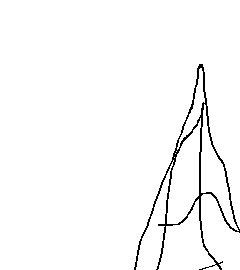

In [109]:
visualize_stroke(reversed_strokes[:5])

In [ ]:
# Lists to collect embeddings and positions
embedding_sample_list = []
inp_pos_list = []

# Process only the first two strokes
for stroke in drawing_resampled[:2]:
    input_seq_len_tensor, input_stroke_tensor = formalize_input(stroke)
    output = encode_stroke(input_seq_len=input_seq_len_tensor, 
                           input_stroke=input_stroke_tensor)
    embedding_sample = output["embedding_sample"]
    
    # Extract the first point's coordinates as position
    inp_pos = [[stroke[0][0], stroke[1][0]]]
    inp_pos_list.extend(inp_pos)
    embedding_sample_list.append(embedding_sample)

# Convert lists to tensors with the right shape
inp_pos_tensor = tf.convert_to_tensor(inp_pos_list, dtype=tf.float32)  # Shape: (num_strokes, 2)
inp_embeddings_tensor = tf.concat(embedding_sample_list, axis=0)  # Shape: (num_strokes, 8)

# Add batch dimension
inp_pos_tensor = tf.expand_dims(inp_pos_tensor, axis=0)  # Shape: (1, num_strokes, 2)
inp_embeddings_tensor = tf.expand_dims(inp_embeddings_tensor, axis=0)  # Shape: (1, num_strokes, 8)

## Try the predict_position signature

In [ ]:
predict_position = model.signatures["predict_position"]
predict_position

In [ ]:
predict_position_result = predict_position(inp_pos=inp_pos_tensor, 
                                           inp_embeddings=inp_embeddings_tensor)
predict_position_result

In [ ]:
target_pos = predict_position_result['position_sample']
target_pos_tensor = tf.expand_dims(target_pos, axis=0)

## Try predict_embedding signature

In [20]:
predict_embedding = model.signatures["predict_embedding"]
predict_embedding

<ConcreteFunction signature_wrapper(inp_embeddings, inp_pos, target_pos) at 0x2E748ED10>

In [ ]:
predict_embedding_result = predict_embedding(inp_pos=inp_pos_tensor, 
                                             target_pos=target_pos_tensor,
                                             inp_embeddings=inp_embeddings_tensor)
predict_embedding_result

## Try the decode_stroke signature

In [21]:
decode_stroke = model.signatures["decode_stroke"]
decode_stroke

<ConcreteFunction signature_wrapper(embedding_sample, target_seq_len) at 0x2C5BCB290>

In [ ]:
# Use the (real) next stroke to determine the target_seq_len for the decoder
target_seq_len_tensor = tf.convert_to_tensor(len(drawing_resampled[2]), dtype=tf.int32)

decode_stroke_result = decode_stroke(embedding_sample = predict_embedding_result["embedding_sample"],
                                     target_seq_len = target_seq_len_tensor)

decode_stroke_result["stroke"]
# This decoded stroke with pen state and stroke are used as the new input 
# for the encoder, whose starting position and embeddings will be used
# for auto-regressive for the remaining stokes

In [ ]:
decode_stroke_result['pen']

# Random Try

In [ ]:
# def process_drawing_for_encode_stroke(drawing):
#     flat_strokes = []
#     total_points = 0
#     for stroke in drawing:
#         for i in range(len(stroke[0])):  # Iterate through points in the stroke
#             x = stroke[0][i]
#             y = stroke[1][i]
#             # Assuming the third list contains timing information, not directly used here
#             # If there's a specific "pen state" value needed, adjust accordingly
#             flat_strokes.append([x, y, 1])  # Use '1' as a placeholder for pen state
#         total_points += len(stroke[0])
    
#     # Convert to tensors
#     input_stroke = tf.constant(flat_strokes, dtype=tf.float32)
#     input_seq_len = tf.constant([total_points], dtype=tf.int32)
    
#     return input_stroke, input_seq_len

# # Find the maximum sequence length across all processed drawings
# max_seq_len = max(input_stroke.shape[0] for input_stroke, _ in processed_drawings)

# # Pad each drawing sequence to the maximum length
# padded_drawings = []
# for input_stroke, input_seq_len in processed_drawings:
#     # Calculate the padding amounts
#     padding = [[0, max_seq_len - tf.shape(input_stroke)[0]], [0, 0]]  # Pad the sequence length to max_seq_len
    
#     # Pad the stroke data
#     padded_stroke = tf.pad(input_stroke, padding, "CONSTANT")
    
#     # Append the padded stroke and original sequence length
#     padded_drawings.append((padded_stroke, input_seq_len))

# padded_drawings

# import json

# processed_drawings = []

# # Draw a sample of 320 sketches
# max_rows = 320
# current_row = 0

# with open("data_dir/quick_draw/raw_Eiffel_Tower.ndjson", 'r') as f:
#     for line in f:
#         if current_row < max_rows:
#             drawing_data = json.loads(line)
#             drawing = drawing_data["drawing"]
#             processed_drawing = process_drawing_for_encode_stroke(drawing)
#             processed_drawings.append(processed_drawing)
#             current_row += 1
#         else:
#             break
# stroke_tensors = [x[0] for x in padded_drawings]
# seq_len_tensors = [x[1] for x in padded_drawings]

# stroke_dataset = tf.data.Dataset.from_tensor_slices(stroke_tensors)
# seq_len_dataset = tf.data.Dataset.from_tensor_slices(seq_len_tensors)

# # Combine into a single dataset
# dataset = tf.data.Dataset.zip((stroke_dataset, seq_len_dataset))

# dataset

# # Set your desired batch size
# batch_size = 128

# # Batch the dataset. No need to specify padding values or shapes here because
# # your tensors within each dataset element already have a uniform shape after padding.
# batched_dataset = dataset.batch(batch_size)

In [ ]:
# # Define the features of importance for input formatting
# feature_description = {
#     'ink': tf.io.VarLenFeature(tf.float32),
# }

# # For now, I use a very small sample of dataset
# file_paths = "data_dir/quick_draw/training/raw_Eiffel_Tower-00000-of-00010"
# dataset = tf.data.TFRecordDataset(file_paths)

# # for raw_record in dataset.take(1):
# #   example = tf.train.Example()
# #   example.ParseFromString(raw_record.numpy())
# #   print(example)

# # Parse a Tensorflow Example proto 
# parsed_dataset = dataset.map(lambda x: tf.io.parse_single_example(x, feature_description)) 

# # Define a function to get the `input_seq_len` and `input_stroke` arguments 
# # for fitting the pretrained model (specifically, `encode_stroke` signature)
# max_length_threshold = 201

# def get_input_arguments(parsed_record):
#     # Reshape and extract the first three dimensions from parsed_record['ink']
#     # (x coordinate, y coordinate, and pen state)
#     ink = tf.sparse.to_dense(parsed_record['ink'])
#     input_seq_len = tf.shape(ink)[0] // 4
#     ink_reshaped = tf.reshape(ink, (input_seq_len, 4))
#     # Expand the input_stroke to three dimensions for batching 
#     input_stroke = tf.expand_dims(ink_reshaped[:, :3], axis=0)
    
#     # Make sure it matches the input shape 
#     input_seq_len = tf.reshape(input_seq_len, [1]) 

#     return input_seq_len, input_stroke
    
# preprocessed_dataset = parsed_dataset.map(get_input_arguments)